# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The dataset collected is related to **17 campaigns** that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts. During these phone campaigns, an attractive long-term deposit application, with good interest rates, was offered. For each contact, a large number of attributes was stored and if there was a success (the target variable). For the whole database considered, there were 6499 successes (8% success rate).

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [6]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, export_graphviz
import graphviz

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from scipy.optimize import minimize

In [7]:
df = pd.read_csv('../data/bank-additional-full.csv', sep = ';')

In [8]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


### Problem 3: Understanding the Features

Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.

**Input variables:**

**bank client data:**

1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')

**related with the last contact of the current campaign:**

8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

**other attributes:**

12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

**social and economic context attributes**

16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

**Output variable (desired target):**

21. y - has the client subscribed a term deposit? (binary: 'yes','no')


#### Missing Values Analysis

In [11]:
df.isnull().sum() # No missing values

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [12]:
df.duplicated().sum() # 12 duplicate rows to be deleted

12

In [13]:
# Remove duplicate rows
df = df.drop_duplicates()

**Summary of Potential Issues:**

- **'unknown' Values:** The categorical features **job, marital, education, default, housing, and loan** contain **'unknown'** values, which may represent missing data. These should be examined and potentially imputed or handled as a separate category.

- **'999' in pdays:** The pdays feature has a value of '999,' indicating that the client was not previously contacted. This value may need special handling, such as treating it as a categorical feature or replacing it with a more informative value.

- **Ordinal Transformation:** The month and day_of_week features might need to be converted into ordinal numeric values.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

### Business Understanding
The **Business Objective** of this task is to optimize the direct marketing efforts of a Portuguese banking institution by predicting whether a client will subscribe to a term deposit based on various client, campaign, and economic indicators. 

By accurately identifying potential subscribers, the bank can increase the efficiency of its marketing campaigns, reduce costs, and improve conversion rates, ultimately leading to better customer targeting and higher profitability.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null  floa

### Exploratory Data Analysis (EDA)

#### **Summary Statistics**
- Generate summary statistics for numeric columns using .describe().
- For categorical columns, use .value_counts() to see the distribution of each category.

In [20]:
# Identify numerical columns
numerical_cols = df.select_dtypes(include=['int','float']).columns.tolist()
print(numerical_cols)

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [21]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


#### **Distribution of Features**
- Visualize the distribution of numeric features using histograms and boxplots.
- For categorical features, use bar plots to visualize the frequency of each category.

In [23]:
for var in numerical_cols:
    print(df[var].value_counts(), '\nlenght:', len(df[var].unique()), '\n\n')

age
31    1947
32    1845
33    1833
36    1779
35    1758
      ... 
89       2
91       2
94       1
87       1
95       1
Name: count, Length: 78, dtype: int64 
lenght: 78 


duration
90      170
85      170
136     168
73      167
124     163
       ... 
1569      1
1053      1
1263      1
1169      1
1868      1
Name: count, Length: 1544, dtype: int64 
lenght: 1544 


campaign
1     17634
2     10568
3      5340
4      2650
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
16       51
15       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
28        8
26        8
25        8
31        7
30        7
35        5
32        4
33        4
34        3
42        2
40        2
43        2
56        1
39        1
41        1
37        1
Name: count, dtype: int64 
lenght: 42 


pdays
999    39661
3        439
6        412
4        118
9         64

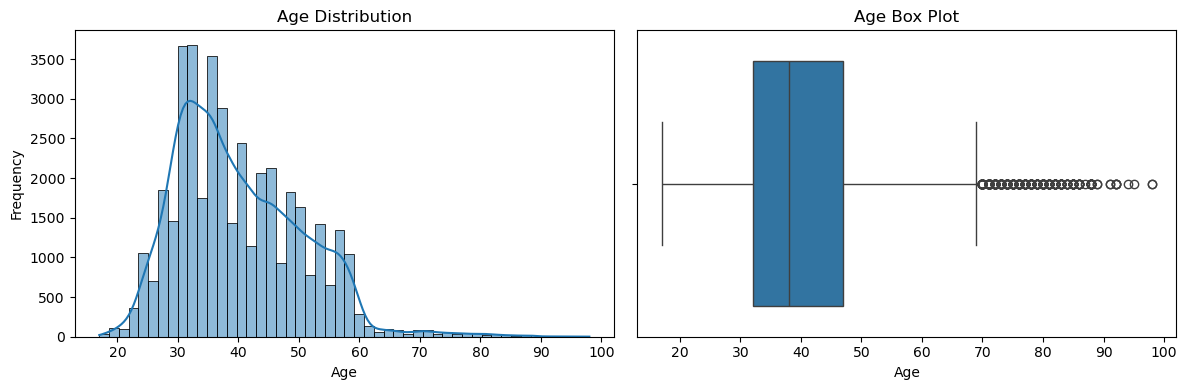

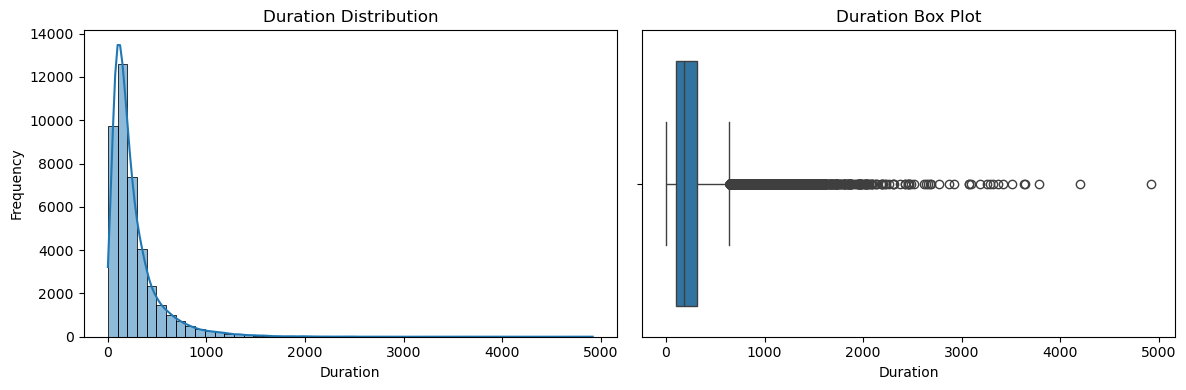

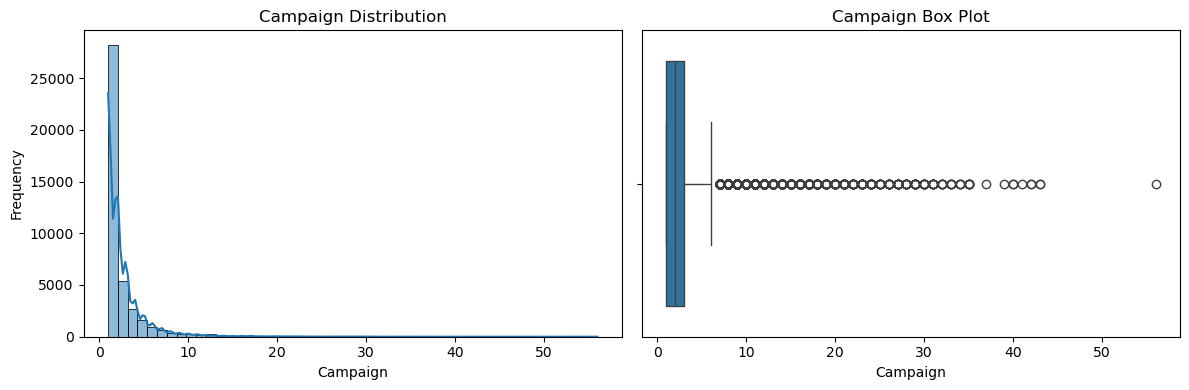

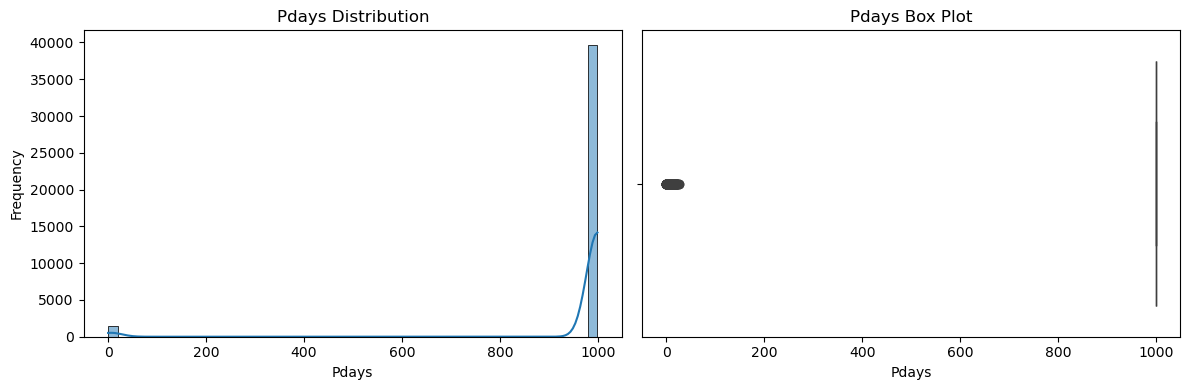

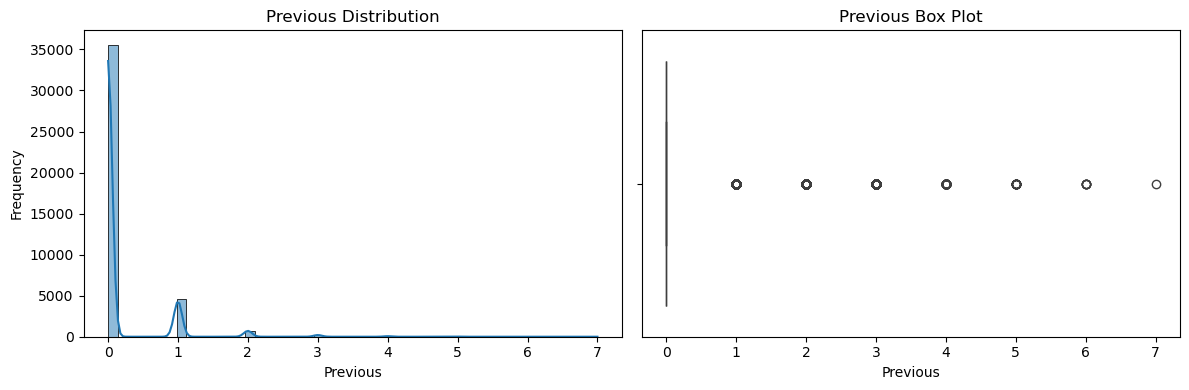

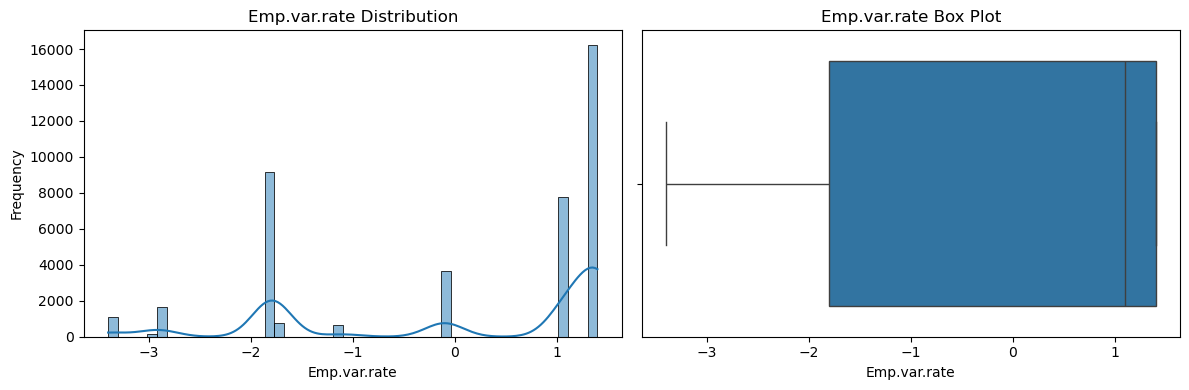

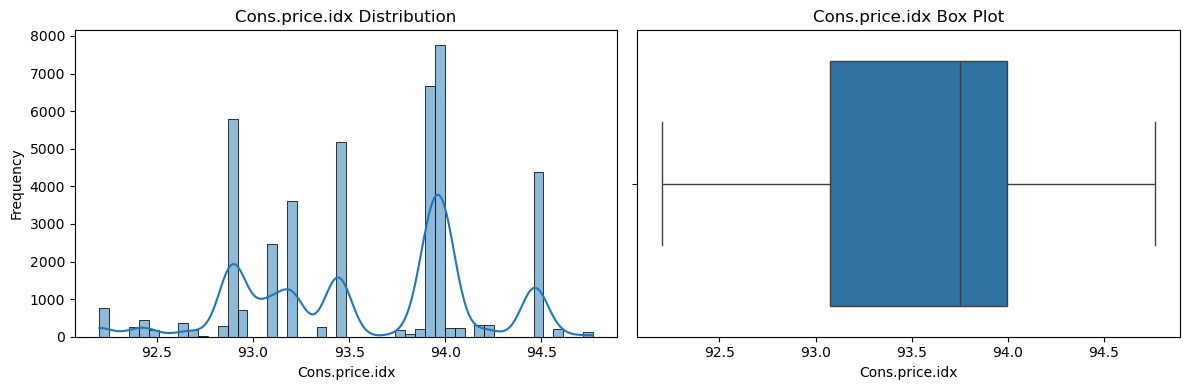

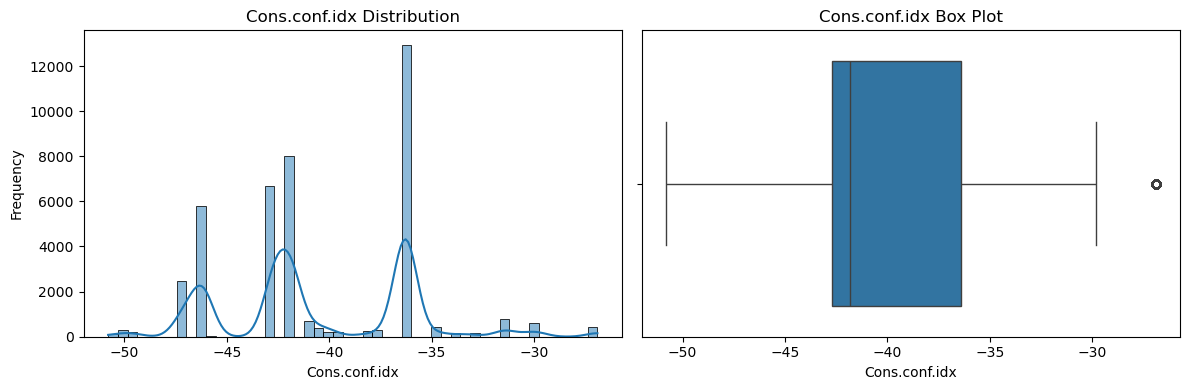

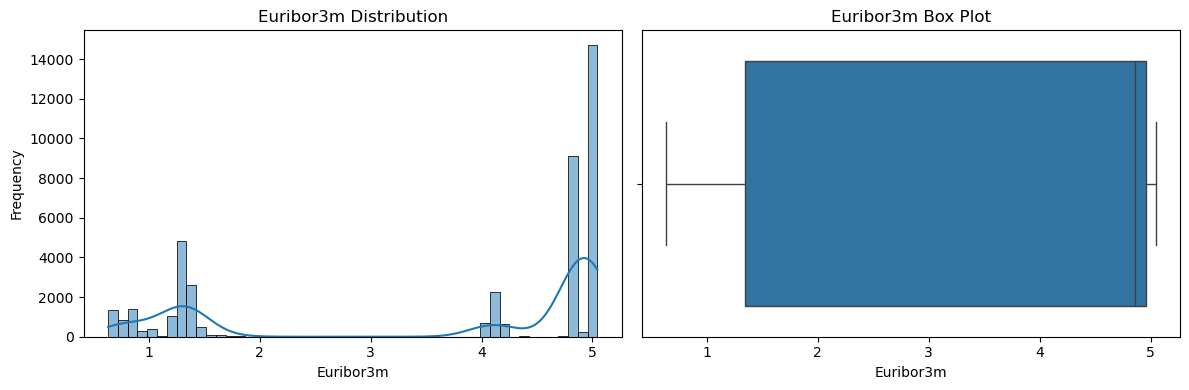

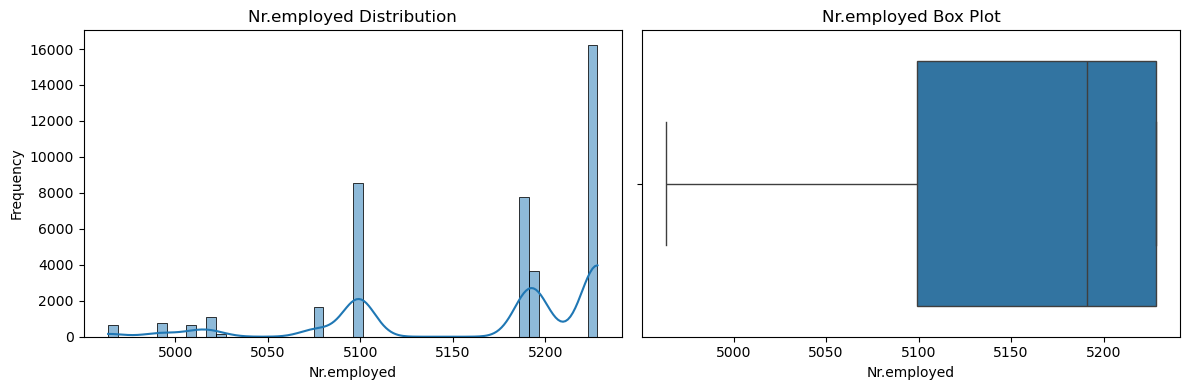

In [24]:
# Loop through each numerical variable and create histograms and density plots
for col in numerical_cols:
    plt.figure(figsize=(12, 4))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[col].dropna(), kde=True, bins=50)
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(col.capitalize())
    plt.ylabel('Frequency')
    
    # Density plot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col].dropna())
    plt.title(f'{col.capitalize()} Box Plot')
    plt.xlabel(col.capitalize())
    
    plt.tight_layout()
    plt.show()

In [25]:
# Identify categorical columns and value counts for each category
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

for var in categorical_cols:
    print(df[var].value_counts(), '\nlenght:', len(df[var].unique()), '\n\n')

job
admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64 
lenght: 12 


marital
married     24921
single      11564
divorced     4611
unknown        80
Name: count, dtype: int64 
lenght: 4 


education
university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: count, dtype: int64 
lenght: 8 


default
no         32577
unknown     8596
yes            3
Name: count, dtype: int64 
lenght: 3 


housing
yes        21571
no         18615
unknown      990
Name: count, dtype: int64 
lenght: 3 


loan
no         33938
yes         6248
unknown      990
Name: count, dtype: int

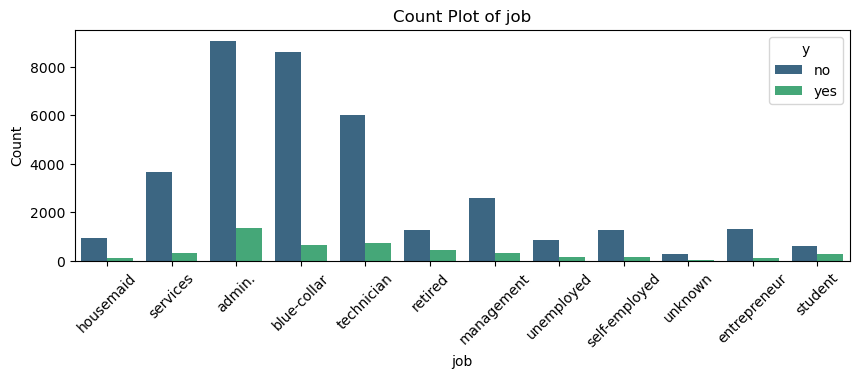

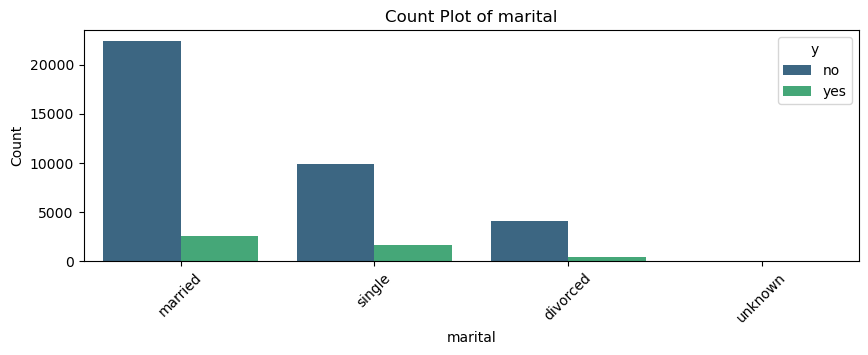

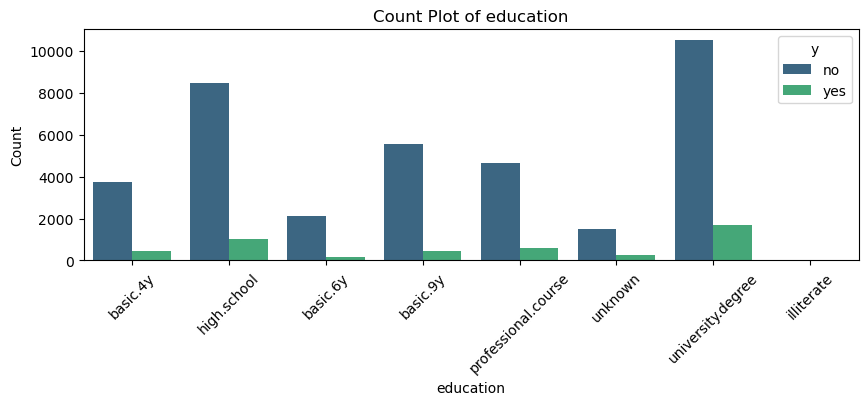

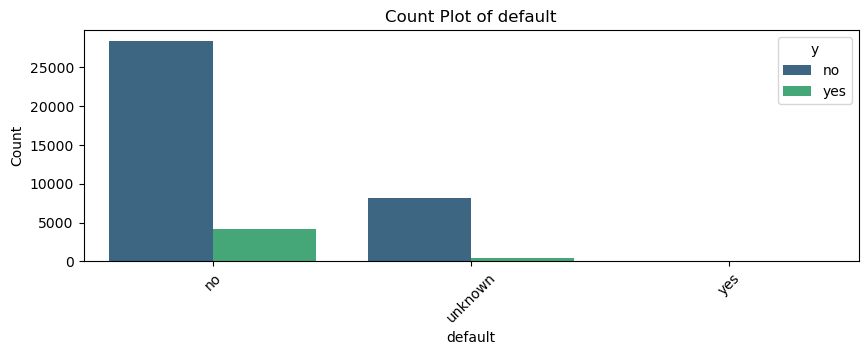

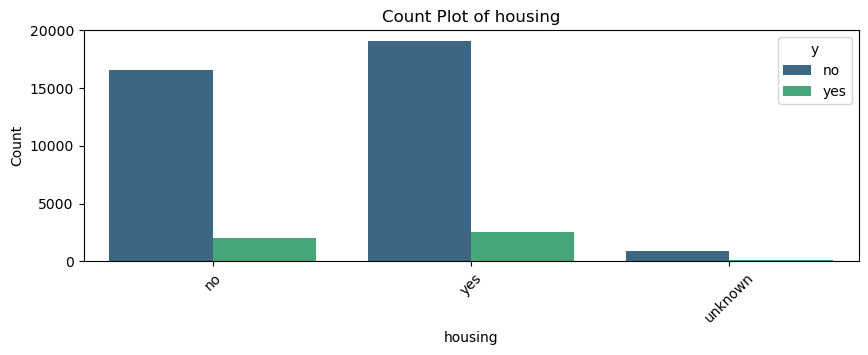

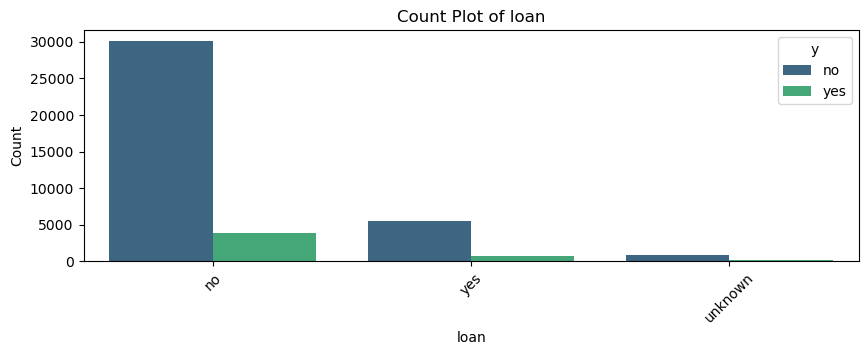

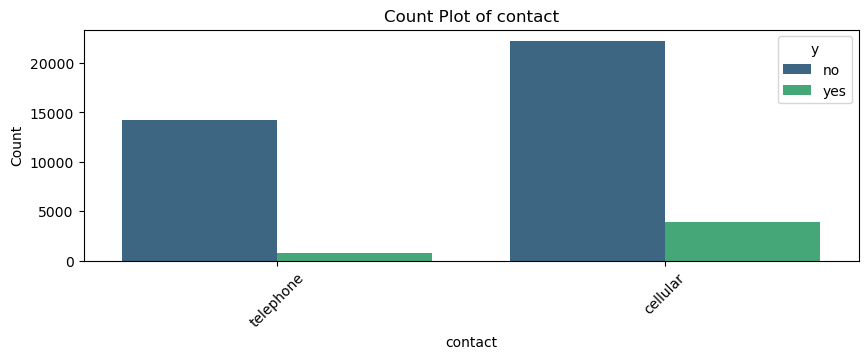

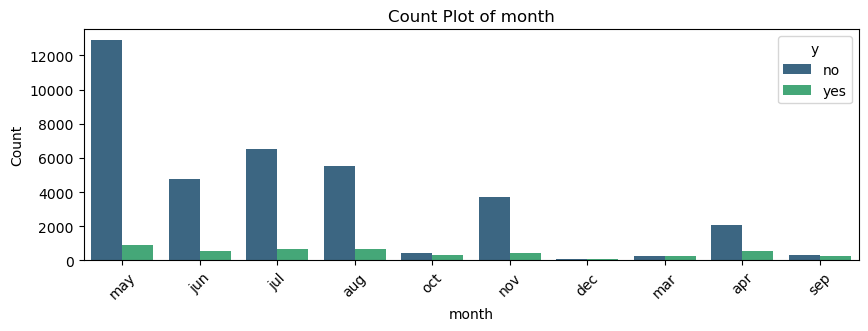

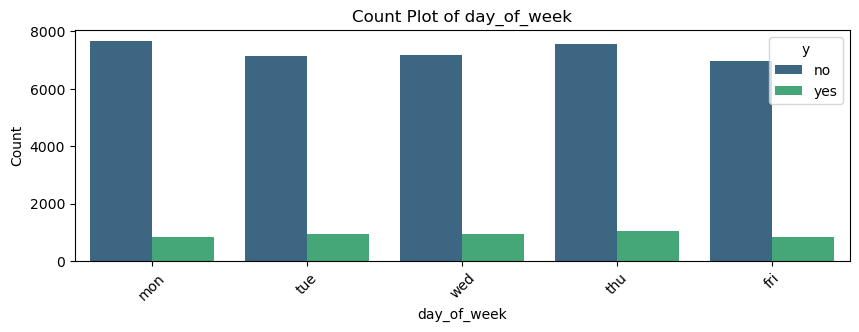

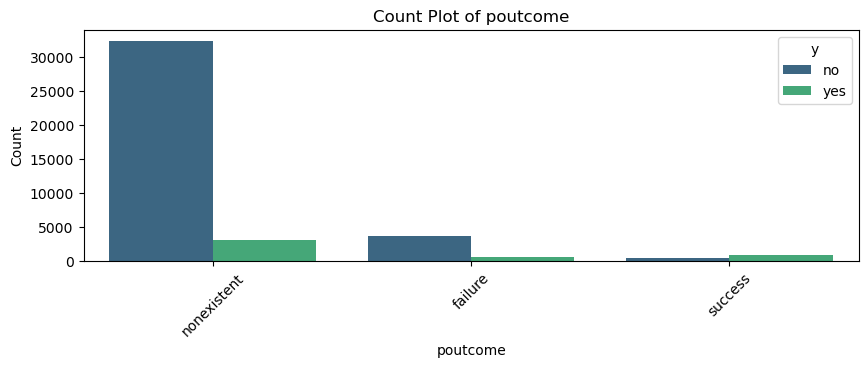

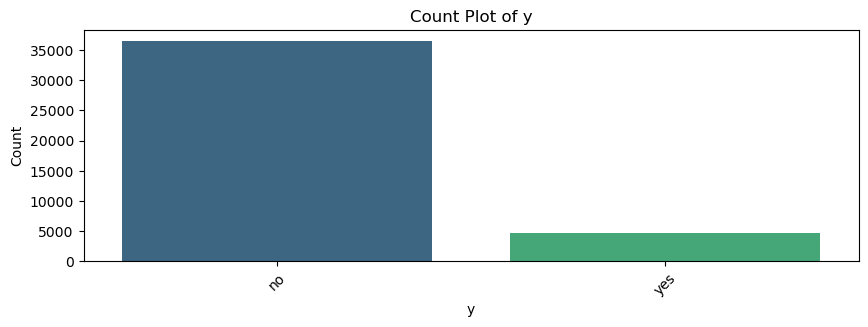

In [26]:
# Loop through each categorical variable and plot histograms to view most popular categories and categorical col distributions
for col in categorical_cols:
    plt.figure(figsize=(10, 3))
    sns.countplot(data=df, x=col, hue='y', palette='viridis')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=45)
    plt.show()

#### **Correlation Analysis**
- Compute the correlation matrix for numeric features using .corr().
- Visualize correlations using a heatmap.
- Explore relationships between features, especially between features and the target variable.
- Use pair plots or scatter plots for this purpose.

In [28]:
df.corr(numeric_only=True)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000808,0.004622,-0.034381,0.024379,-0.000242,0.001009,0.129075,0.010852,-0.017607
duration,-0.000808,1.000000,-0.071765,-0.047556,0.020600,-0.027941,0.005303,-0.008126,-0.032861,-0.044672
campaign,0.004622,-0.071765,1.000000,0.052606,-0.079182,0.150786,0.127826,-0.013657,0.135169,0.144129
pdays,-0.034381,-0.047556,0.052606,1.000000,-0.587508,0.271063,0.078920,-0.091374,0.296946,0.372659
previous,0.024379,0.020600,-0.079182,-0.587508,1.000000,-0.420587,-0.203197,-0.050929,-0.454571,-0.501411
emp.var.rate,-0.000242,-0.027941,0.150786,0.271063,-0.420587,1.000000,0.775293,0.196257,0.972244,0.906949
cons.price.idx,0.001009,0.005303,0.127826,0.078920,-0.203197,0.775293,1.000000,0.059170,0.688180,0.521945
cons.conf.idx,0.129075,-0.008126,-0.013657,-0.091374,-0.050929,0.196257,0.059170,1.000000,0.277864,0.100679
euribor3m,0.010852,-0.032861,0.135169,0.296946,-0.454571,0.972244,0.688180,0.277864,1.000000,0.945146
nr.employed,-0.017607,-0.044672,0.144129,0.372659,-0.501411,0.906949,0.521945,0.100679,0.945146,1.000000


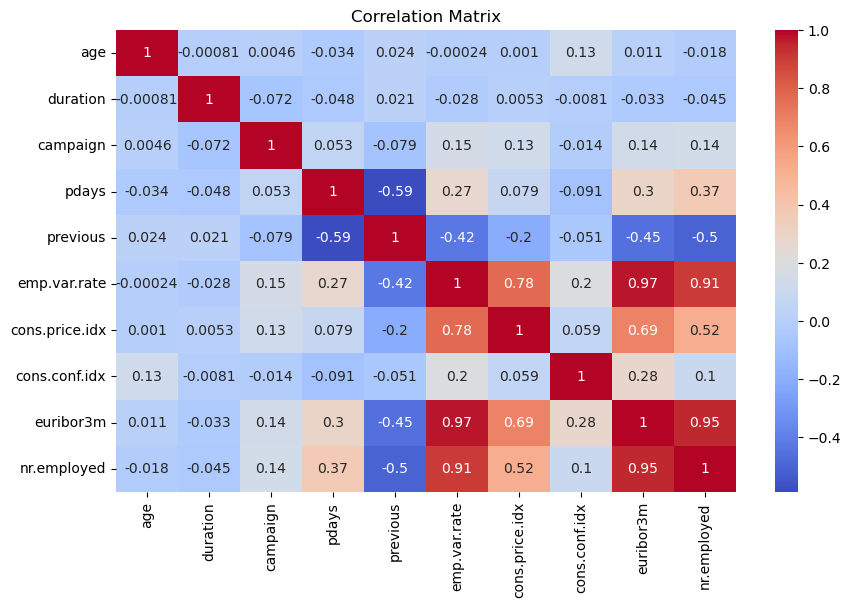

In [29]:
# Visualize correlations
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
sns.pairplot(df, hue='y')
plt.show()

In [ ]:
num_cols = len(categorical_cols)  # Get the number of categorical columns

# Calculate the number of rows to create for the subplots
rows = (num_cols + 1) // 2  # Integer division for ceiling

# Create the figure with subplots
fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 3))  # Adjust figsize based on desired size

# Loop through categorical columns and create heatmaps
col_idx = 0
for row in range(rows):
  for col in range(2):
    if col_idx >= len(categorical_cols):
      break  # No more columns to process
    cross_tab = pd.crosstab(df[categorical_cols[col_idx]], df['y'], normalize='index')
    ax = axes[row, col]  # Get the current subplot axis
    sns.heatmap(cross_tab, ax=ax, annot=True, cmap='YlGnBu', fmt='.2f')
    ax.set_title(f'Heatmap for {categorical_cols[col_idx]} vs. y')
    ax.set_xlabel('y')
    ax.set_ylabel(categorical_cols[col_idx])
    col_idx += 1

# Adjust layout (optional)
plt.tight_layout()  # Adjust spacing between subplots

plt.show()

#### **Target Variable Analysis**
- Analyze the distribution of the target variable y.
- Compare the distribution of features for the two classes (yes and no).

In [ ]:
df['y'].value_counts(normalize=True)

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [ ]:
# Split data into features (X) and target (y)
X = df.drop('y', axis=1)
X_oe = df.drop('y', axis=1)
y = df['y']

In [ ]:
# Identify Categorical and Numerical cols
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int','float']).columns.tolist()

In [ ]:
print('categorical_cols and length:', len(categorical_cols), categorical_cols)
print('numerical_cols and length:', len(numerical_cols), numerical_cols)

In [ ]:
# Preprocessor for logistic, KNN, SVM
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OrdinalEncoder(), categorical_cols)
    ])
# for Decision Tree, although results seems to be same with scaling, scaling is not required, it's better for interpretability
ordinal_encoder = OrdinalEncoder()

In [ ]:
X_txd = preprocessor.fit_transform(X)

In [ ]:
X_txd

In [ ]:
X1 = pd.DataFrame(X_txd, columns=[numerical_cols+categorical_cols])
X1

In [ ]:
X_oe[categorical_cols] = ordinal_encoder.fit_transform(X_oe[categorical_cols])

In [ ]:
X_oe

In [ ]:
# Get the mapping of categories to integers
category_mapping = {col: dict(zip(ordinal_encoder.categories_[i], range(len(ordinal_encoder.categories_[i])))) for i, col in enumerate(categorical_cols)}

# Display the category_mapping
for col, mapping in category_mapping.items():
    print(f"{col}: {mapping}")

In [ ]:
# Encode target variable
label_encoder = LabelEncoder()
y_txd = label_encoder.fit_transform(y)

In [ ]:
y_txd

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [ ]:
# Split data into training and testing sets for Logistic, KNN, SVM
X_train, X_test, y_train, y_test = train_test_split(X_txd, y_txd, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
y_train.shape, y_test.shape

In [ ]:
# Split data into training and testing sets for Decision Tree for Interpretability
X_train_oe, X_test_oe, y_train, y_test = train_test_split(X_oe, y_txd, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_train_oe.shape, X_test_oe.shape

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

#### Zero-Rule Classifier
- Always predicts the most frequent class.
- Useful for imbalanced datasets.
- Provides a lower bound on performance.

In [ ]:
# Create a Zero-Rule Classifier
zero_rule_clf = DummyClassifier(strategy="most_frequent")
zero_rule_clf.fit(X_train, y_train)

# Make predictions
y_pred = zero_rule_clf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Zero-Rule Classifier Accuracy:", round(accuracy,2))
# print(classification_report(y_test, y_pred)) # results in `zero_division` for Precision and Precision, Recall, F1 = 0.

#### Random Classifier
- Predicts a random class for each instance.
- Gives a sense of how random guessing would perform.

In [ ]:
# Create a Random Classifier
random_clf = DummyClassifier(strategy="uniform")
random_clf.fit(X_train, y_train)

# Make predictions
y_pred = random_clf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Random Classifier Accuracy:", round(accuracy,2))
print(classification_report(y_test, y_pred))

#### Majority Class Classifier
- Similar to ZeroR but can be used for multi-class problems.
- Predicts the most frequent class for all instances.

In [ ]:
from collections import Counter

# Determine the most frequent class
most_frequent_class = Counter(y_train).most_common(1)[0][0]

# Create predictions
y_pred = [most_frequent_class] * len(y_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Majority Class Classifier Accuracy:", round(accuracy,2))
# print(classification_report(y_test, y_pred)) # results in `zero_division` for Precision and Precision, Recall, F1 = 0.

**Choosing the Right Baseline**
The best baseline depends on your specific problem and dataset:

- **Imbalanced datasets:** Zero-Rule Classifier is often a good choice.
- **Multi-class problems:** Majority Class Classifier is suitable.
- **General case:** Random Classifier can be a starting point.

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [ ]:
# Create a logistic regression model
log_reg = LogisticRegression()

# Fit the model on training data
log_reg.fit(X_train, y_train)

# Make predictions on test data
y_pred = log_reg.predict(X_test)

### Problem 9: Score the Model

What is the accuracy of your model?

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", round(accuracy,2))

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [ ]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True)
}

In [ ]:
# Train and evaluate models
results = {}

for name, model in models.items():
    
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    y_prob = model.predict_proba(X_test)[:, 1]  # Probability of the positive class
    auc = roc_auc_score(y_test, y_prob)

    results[name] = {
        'Model': name,
        'Train Time': train_time,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'precision':precision,
        'recall': recall,
        'f1': f1,
        'AUC': auc,
        'y pred': y_pred,
        'y_prob': y_prob
    }

    print(f"{name}: Train Time = {train_time:.2f}, Train Accuracy = {train_accuracy:.2f}, Test Accuracy = {test_accuracy:.2f}, Precision = {precision:.2f}, Recall = {recall:.2f}, F1 = {f1:.2f}, AUC = {auc:.2f}")

In [ ]:
results_df = pd.DataFrame(results).transpose().reset_index(drop=True)

In [ ]:
results_df

In [ ]:
plt.figure(figsize=(6,3))
sns.lineplot(results_df, x='Model', y='Train Time')
plt.title('Compare Train Time for models')
plt.show()

In [ ]:
# Define the metrics to plot
metrics = ['Train Accuracy', 'Test Accuracy', 'precision', 'recall', 'f1', 'AUC']
plt.figure(figsize=(8,3))

# Plot each metric
for metric in metrics:
    sns.lineplot(data=results_df, x='Model', y=metric, label=metric)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Compare scores for models')
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))  # Create a 2x2 grid of subplots
fig.suptitle('ROC Curves for Models')  # Add a title for the entire figure

# Counter to keep track of subplot position
plot_count = 0

for index, row in results_df.iterrows():
    model = row['Model']
    y_prob = row['y_prob']

    # Access current subplot based on counter
    ax = axes.flat[plot_count]  # Flattened array for easier access
    
    # Visualizing ROC Curve

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    ax.plot(fpr, tpr)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f"Model: {model}, AUC = {round(row['AUC'],2)}")

    plot_count += 1

# Adjust layout to prevent overlapping elements (optional)
plt.tight_layout()

plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))  # Create a 2x2 grid of subplots
fig.suptitle('Confusion Matrix for Models')  # Add a title for the entire figure

# Counter to keep track of subplot position
plot_count = 0

for index, row in results_df.iterrows():
    model = row['Model']
    y_pred = row['y pred']  # Use lowercase 'd' for predicted labels

    # Access current subplot based on counter
    ax = axes.flat[plot_count]  # Flattened array for easier access

    # Visualizing Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
    ax.set_title(f"{model}: Confusion Matrix")

    plot_count += 1

# Adjust layout to prevent overlapping elements (optional)
plt.tight_layout()

plt.show()

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Logistic Regression

In [ ]:
%%time
logreg = LogisticRegression(max_iter=1000)

logreg_params = {
    'C': [0.001, 0.01, 0.1, 1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

logreg_grid = GridSearchCV(logreg, param_grid=logreg_params, cv=5, scoring='accuracy')

start_time = time.time()
logreg_grid.fit(X_train, y_train)
end_time = time.time()

In [ ]:
logreg_execution_time = end_time - start_time

logreg_grid_best_params = logreg_grid.best_params_
logreg_grid_train_score = logreg_grid.score(X_train, y_train)
logreg_grid_test_score = logreg_grid.score(X_test, y_test)

print('logreg_grid_best_params: ', logreg_grid_best_params)
print('logreg_grid_train_score: ', round(logreg_grid_train_score,2))
print('logreg_grid_test_score: ', round(logreg_grid_test_score,2))
print('logreg_execution_time: ', round(logreg_execution_time,2), 's')

In [ ]:
y_pred_logreg = logreg_grid.best_estimator_.predict(X_test)

logreg_precision_score = precision_score(y_test, y_pred_logreg)
logreg_recall_score = recall_score(y_test, y_pred_logreg)
logreg_f1_score = f1_score(y_test, y_pred_logreg)

print('logreg_precision_score: ', round(logreg_precision_score,2))
print('logreg_recall_score: ', round(logreg_recall_score,2))
print('logreg_f1_score: ', round(logreg_f1_score,2))

print(classification_report(y_test, y_pred_logreg))

In [ ]:
y_prob_logreg = logreg_grid.best_estimator_.predict_proba(X_test)[:, 1]
auc_logreg = roc_auc_score(y_test, y_prob_logreg)
print(f"AUC = {auc_logreg:.2f}")

In [ ]:
cols = numerical_cols+categorical_cols
print(cols)

In [ ]:
# Retrieve the coefficients
coefficients = logreg_grid.best_estimator_.coef_[0]
intercept = logreg_grid.best_estimator_.intercept_[0]

# Create a DataFrame to display the coefficients along with their feature names
coeff_df = pd.DataFrame({
    'Feature': cols,
    'Coefficient': coefficients
})
print("Intercept:", intercept)

In [ ]:
# Plotting the coefficients using matplotlib and seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coeff_df)
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

#### Decision Trees

In [ ]:
%%time
dtree = DecisionTreeClassifier()

dtree_params = {
    'max_depth': [None, 2, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dtree_grid = GridSearchCV(dtree, param_grid=dtree_params, cv=5, scoring='accuracy')

start_time = time.time()
dtree_grid.fit(X_train_oe, y_train)
end_time = time.time()

In [ ]:
dtree_execution_time = end_time - start_time
dtree_grid_best_params = dtree_grid.best_params_
dtree_grid_train_score = dtree_grid.score(X_train_oe, y_train)
dtree_grid_test_score = dtree_grid.score(X_test_oe, y_test)
print('dtree_grid_best_params: ', dtree_grid_best_params)
print('dtree_grid_train_score: ', round(dtree_grid_train_score,2))
print('dtree_grid_test_score: ', round(dtree_grid_test_score,2))
print('dtree_execution_time: ', round(dtree_execution_time,2), 's')

In [ ]:
#dtree_grid.best_estimator_.get_depth()

In [ ]:
y_pred_dtree = dtree_grid.best_estimator_.predict(X_test_oe)
dtree_precision_score = precision_score(y_test, y_pred_dtree)
dtree_recall_score = recall_score(y_test, y_pred_dtree)
dtree_f1_score = f1_score(y_test, y_pred_dtree)
print('dtree_precision_score: ', round(dtree_precision_score,2))
print('dtree_recall_score: ', round(dtree_recall_score,2))
print('dtree_f1_score: ', round(dtree_f1_score,2))
print(classification_report(y_test, y_pred_dtree))

In [ ]:
y_prob_dtree = dtree_grid.best_estimator_.predict_proba(X_test_oe)[:, 1]
auc_dtree = roc_auc_score(y_test, y_prob_dtree)
print(f"AUC = {auc_dtree:.2f}")

In [ ]:
tree_plot = plot_tree(dtree_grid.best_estimator_ , feature_names = X_test_oe.columns.tolist(), filled=True)
tree_plot

In [ ]:
# A more readable output
fig, ax = plt.subplots(figsize = (20, 20))
plot_tree(dtree_grid.best_estimator_, feature_names=X_test_oe.columns.tolist(), filled=True, ax = ax, fontsize=8);

In [ ]:
# Retrieve the feature importances
importances = dtree_grid.best_estimator_.feature_importances_

# Create a DataFrame to display the feature importances along with their feature names
importances_df_dtree = pd.DataFrame({
    'Feature': X_train_oe.columns.tolist(),
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotting the feature importances using matplotlib and seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df_dtree)
plt.title('Decision Tree Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
# Extract and display the decision rules
tree_rules = export_text(dtree_grid.best_estimator_, feature_names=X_train_oe.columns.tolist())
print(tree_rules)

In [ ]:
# Export the decision tree to a dot file
dot_data = export_graphviz(dtree_grid.best_estimator_, out_file=None, feature_names=X_train_oe.columns,  
                           class_names=['no', 'yes'], filled=True, rounded=True, special_characters=True)

# Render the dot file as a graph
graph = graphviz.Source(dot_data)

# Render and save the graph to the specified path
graph.render("../images/decision_tree", format='pdf')

#### KNN

In [ ]:
%%time
knn = KNeighborsClassifier()
knn_params = {
    'n_neighbors': list(range(1, 22, 2)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
knn_grid = GridSearchCV(knn, param_grid=knn_params, cv=5, scoring='accuracy')

start_time = time.time()
knn_grid.fit(X_train, y_train)
end_time = time.time()

In [ ]:
knn_execution_time = end_time - start_time
knn_grid_best_params = knn_grid.best_params_
knn_grid_train_score = knn_grid.score(X_train, y_train)
knn_grid_test_score = knn_grid.score(X_test, y_test)
print('knn_grid_best_params: ', knn_grid_best_params)
print('knn_grid_train_score: ', round(knn_grid_train_score,2))
print('knn_grid_test_score: ', round(knn_grid_test_score,2))
print('knn_execution_time: ', round(knn_execution_time,2), 's')

In [ ]:
y_pred_knn = knn_grid.best_estimator_.predict(X_test)
knn_precision_score = precision_score(y_test, y_pred_knn)
knn_recall_score = recall_score(y_test, y_pred_knn)
knn_f1_score = f1_score(y_test, y_pred_knn)
print('knn_precision_score: ', round(knn_precision_score,2))
print('knn_recall_score: ', round(knn_recall_score,2))
print('knn_f1_score: ', round(knn_f1_score,2))
print(classification_report(y_test, y_pred_knn))

In [ ]:
y_prob_knn = knn_grid.best_estimator_.predict_proba(X_test)[:, 1]
auc_knn = roc_auc_score(y_test, y_prob_knn)
print(f"AUC = {auc_knn:.2f}")

In [ ]:
# Compute permutation feature importance
result = permutation_importance(knn_grid.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Create a DataFrame to display the feature importances along with their feature names
knn_importances_df = pd.DataFrame({
    'Feature': cols,
    'Importance': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance', ascending=False)

# Plotting the feature importances using matplotlib and seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=knn_importances_df)
plt.title('KNN Feature Importances (Permutation Importance)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### SVM

In [ ]:
%%time
kernels = ['linear', 'poly', 'rbf']
cv_scores = []
for k in kernels:
    svc = SVC(kernel=k)
    scores = cross_val_score(svc, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_kernel = kernels[cv_scores.index(max(cv_scores))]
print(f"Optimal kernel is {optimal_kernel} with cross-validation score of {max(cv_scores)}")

In [ ]:
%%time

svm = SVC(probability=True)
svm_params = {
    'kernel': [optimal_kernel],
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1]
}

In [ ]:
svm_grid = GridSearchCV(svm, param_grid=svm_params, cv=5, scoring='accuracy')

**SVM Summary**
SVM is computationally very expensive at this point, unable to fit the model in the local system with all the data and features.
- Optimal kernel is rbf with cross-validation score of 0.9075288403157256
- CPU times: user 5min 46s, sys: 4.73 s, total: 5min 51s
- Wall time: 5min 55s from step 1.

#### Results Summary

In [ ]:
results_df_improved = ''
res_dict = {
    'Model': ['Logistic Regression', 'Decision Trees', 'KNN'],
    'Train Time': [logreg_execution_time, dtree_execution_time, knn_execution_time],
    'Train Accuracy': [logreg_grid_train_score, dtree_grid_train_score, knn_grid_train_score],
    'Test Accuracy': [logreg_grid_test_score, dtree_grid_test_score, knn_grid_test_score],
    'Precision': [logreg_precision_score, dtree_precision_score, knn_precision_score],
    'Recall': [logreg_recall_score, dtree_recall_score, knn_recall_score],
    'F1': [logreg_f1_score, dtree_f1_score, knn_f1_score],
    'AUC': [auc_logreg, auc_dtree, auc_knn],
    'y_pred': [y_pred_logreg, y_pred_dtree, y_pred_knn],
    'y_prob': [y_prob_logreg, y_prob_dtree, y_prob_knn]
}
results_df_improved = pd.DataFrame(res_dict)

In [ ]:
results_df_improved

In [ ]:
# Compare Train Time for models

plt.figure(figsize=(6,3))
sns.lineplot(results_df_improved, x='Model', y='Train Time')
plt.title('Compare Train Time for models')
plt.show()

In [ ]:
# Compare scores for models

# Define the metrics to plot
metrics = ['Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
plt.figure(figsize=(8,3))

# Plot each metric
for metric in metrics:
    sns.lineplot(data=results_df_improved, x='Model', y=metric, label=metric)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Compare scores for models')
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))  # Create a 2x2 grid of subplots
fig.suptitle('ROC Curves for Models')  # Add a title for the entire figure

# Counter to keep track of subplot position
plot_count = 0

for index, row in results_df_improved.iterrows():
    model = row['Model']
    y_prob = row['y_prob']

    # Access current subplot based on counter
    ax = axes.flat[plot_count]  # Flattened array for easier access
    
    # Visualizing ROC Curve

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    ax.plot(fpr, tpr)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f"Model: {model}, AUC = {round(row['AUC'],2)}")

    plot_count += 1

# Adjust layout to prevent overlapping elements (optional)
plt.tight_layout()

plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Create a 2x2 grid of subplots
fig.suptitle('Confusion Matrix for Models')  # Add a title for the entire figure

# Counter to keep track of subplot position
plot_count = 0

for index, row in results_df_improved.iterrows():
    model = row['Model']
    y_pred = row['y_pred']  # Use lowercase 'd' for predicted labels

    # Access current subplot based on counter
    ax = axes.flat[plot_count]  # Flattened array for easier access

    # Visualizing Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
    ax.set_title(f"{model}: Confusion Matrix")

    plot_count += 1

# Adjust layout to prevent overlapping elements (optional)
plt.tight_layout()
plt.show()

### Summary / Findings

- Decision Tree has best Performance, AUC comparable to Logistic Regression at 0.93 and best F1 at 0.57, scope for further improvement with feature selection or Tree Pruning, to be further evaluated.
- Training time is minimal as compared to computationally expensive KNN and SVM.

### Interpretation of the Decision Tree

#### Segment 1: Low Employment, Short Call Duration

- **Characteristics**: Customers in regions with low employment rates (`nr.employed <= 5087.65`) and short call durations (`duration <= 162.5` seconds).
- **Behavior**:
  - If these customers have had few previous contacts (`pdays <= 6.5`) and are early in the campaign (`campaign <= 3.5`), they are generally less likely to subscribe unless the call duration is slightly longer (`duration > 136.5` seconds).
  - For customers with more previous contacts (`pdays > 6.5`), shorter call durations typically lead to non-subscriptions, regardless of economic indicators (`cons.price.idx`).
- **Recommendations**:
  - **Short Duration, Few Contacts**: Engage these customers by extending conversations and focusing on understanding their needs. 
  - **More Contacts**: Reinforce the benefits of the term deposit, especially by introducing new information or incentives not previously discussed.

#### Segment 2: Low Employment, Long Call Duration

- **Characteristics**: Customers in low employment regions with longer call durations (`duration > 162.5` seconds).
- **Behavior**:
  - More likely to subscribe, particularly if there have been few prior contacts (`pdays <= 16.5`) and they are still in the early or middle stages of the campaign (`campaign <= 6.5`).
  - Economic context (`cons.price.idx <= 92.56`) also plays a role, with favorable indicators increasing the likelihood of subscription.
- **Recommendations**:
  - **Engagement**: Use the extended call time to build a strong connection, presenting term deposits as a secure investment option.
  - **Tailoring Offers**: Offer personalized financial solutions and highlight the advantages of term deposits in protecting against inflation or market volatility.

#### Segment 3: High Employment, Short Call Duration

- **Characteristics**: Customers in high employment regions (`nr.employed > 5087.65`) but with short call durations (`duration <= 525.5` seconds).
- **Behavior**:
  - Less likely to subscribe, especially if economic confidence is low (`cons.conf.idx <= -46.65`) and interest rates are moderate (`euribor3m <= 1.53`).
  - These customers may not be engaged enough to commit to a term deposit within a short interaction.
- **Recommendations**:
  - **Understanding Reluctance**: Address their concerns early in the conversation, offering compelling reasons to continue the call or explore additional information online.
  - **Optimizing Channels**: Suggest follow-up emails or digital resources where they can review information at their own pace, potentially leading to more successful re-engagement later.

#### Segment 4: High Employment, Long Call Duration with Favorable Economic Conditions

- **Characteristics**: Customers in regions with high employment, long call durations (`duration > 525.5` seconds), and favorable economic conditions (`euribor3m <= 1.53`, `cons.conf.idx > -46.65`).
- **Behavior**:
  - These customers are more likely to subscribe, especially if the call duration is long and economic indicators are positive.
  - Their engagement suggests a strong interest in securing a term deposit, likely influenced by their favorable economic situation.
- **Recommendations**:
  - **Highlight Benefits**: Emphasize how term deposits can offer security and growth in a stable economic environment. Discuss potential long-term benefits like compound interest.
  - **Cross-Selling**: Leverage their positive disposition to introduce other related financial products, such as retirement accounts or investment services, that align with their goals.

#### Segment 5: High Employment, Long Call Duration with Unfavorable Economic Conditions

- **Characteristics**: Customers in regions with high employment, long call durations, but facing less favorable economic indicators (`euribor3m > 1.53`, `cons.conf.idx <= -46.65`).
- **Behavior**:
  - While these customers have longer call durations, the decision to subscribe is more nuanced and influenced by economic conditions.
  - They may still subscribe, but only if reassured about the safety and reliability of the investment, especially in uncertain times.
- **Recommendations**:
  - **Risk Mitigation**: Provide products that offer flexibility, such as term deposits with shorter lock-in periods or those with higher liquidity. Stress the security of the investment even in a fluctuating economy.
  - **Building Trust**: Focus on transparency and how your financial institution can support them through economic challenges, potentially offering special rates or terms as a sign of goodwill.

### Additional Considerations Using Ordinal Mapping

- **Job and Economic Influence**: Customers in higher-tier jobs (e.g., management, technicians) are more likely to respond positively to detailed financial discussions. Tailor conversations to their perceived job stability and financial acumen.
- **Marital Status**: Single individuals or those with more disposable income (e.g., singles) may be more open to higher-risk investments, while married or divorced customers might prioritize security.
- **Education Level**: Those with higher education levels (e.g., university degree) might respond better to discussions that include financial jargon or more detailed explanations of how term deposits work.
- **Default, Housing, and Loan Status**: Customers without defaults and with a clear financial history might be targeted with more premium offers. Conversely, those with uncertain statuses might benefit from more secure, lower-risk products.

By integrating these additional demographic and socio-economic factors, you can further refine your strategy, ensuring each customer receives a tailored pitch that resonates with their specific circumstances and priorities.

#### Overall Marketing Strategies

- **Tailored Campaigns:** Develop targeted marketing campaigns based on customer segments, focusing on their specific needs and preferences.
- **Call Duration Optimization:** Implement strategies to increase call duration for segments with lower conversion rates.
- **Economic Indicators:** Continuously monitor economic indicators and adjust marketing strategies accordingly.
- **Agent Training:** Equip sales agents with knowledge about different customer segments and how to tailor their approach.
- **Customer Relationship Management (CRM):** Utilize CRM systems to track customer interactions, preferences, and purchase history for personalized marketing.